To solve this problem, we can do two things. One: combine all positive reviews and say how many times did a word appear over the total number of words in that corpus. **Or: For each word, we can say in how many positive reviews did it appear over the total number of positive reviews.** Both give a good (albeit different) measure of probability that we can use. I used the latter approach, but have code for both below.

In [21]:
import glob
import os
from collections import defaultdict
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

**Given a filename, this function remove non-alpabets and return a list of words in the file:**

In [22]:
def processFile(filename):
    f = open(filename, 'r')
    content = f.read()
    content = re.sub('[^A-z \n]','',content)
    return content.split()

**This function loops through the files in our training set and builds a dictionary of counts and takes the log probability:**

See in how many positive reviews a given word occurs in

In [23]:
c = 0.0
def readReview(path,dic):
    global c
    c=0.0
    for filename in glob.glob(os.path.join(path, '*.txt')):
        content=processFile(filename)
        for w in set(content):
            dic[w]+=1
        c+=1
    for k,v in dic.items():
        dic[k]=np.log(v/c)

Here we combine the entire corpus of positive reviews and count how many times a given word occurred in total. This is another approach to the previous code block.

In [24]:
# def readReview(path,dic):
#     content = []
#     for filename in glob.glob(os.path.join(path, '*.txt')):
#         content+=processFile(filename)
#     for w in content:
#         dic[w]+=1
#     global c
#     c=len(content)
#     for k,v in dic.items():
#         dic[k]=np.log(v/float(c))

**We just call the above function and build positive and negative dictionaries:**

In [25]:
path1 = 'movie_reviews/txt_sentoken/pos'
path2 = 'movie_reviews/txt_sentoken/neg'
posdict = defaultdict(int)
negdict = defaultdict(int)
readReview(path1,posdict)
readReview(path2,negdict)

**The next step is important. For each word in positive dictionary but not in the negative one, we set it's value in the negative dictionary to a low threshold (and vice versa):**

In [26]:
for k,v in posdict.items():
    if not negdict[k]:
        negdict[k]=np.log(0.2/c)
for k,v in negdict.items():
    if not posdict[k]:
        posdict[k]=np.log(0.2/c)

**Now, given a test review, we will go through the words in that review and add up the positive probabilities to a postive score and negative probabilities to a negative score.**

The 'thresh' here accounts for the fact that we don't know the prior probabilities. So we can try varies thresholds and pick the one that performed best.

In [27]:
def accuracyCount(path,posdict,negdict,isPositive=True,thresh=0.5):
    poscount = 0
    n = len(glob.glob(os.path.join(path, '*.txt')))
    for filename in glob.glob(os.path.join(path, '*.txt')):
        content=processFile(filename)
        posscore = 0
        negscore = 0
        for w in set(content):
            posscore+=posdict[w]
            negscore+=negdict[w]
        if (posscore>(0.5/thresh)*negscore):
            poscount+=1
    if isPositive:
        return poscount
    else:
        return n-poscount

In [28]:
def test():
    scores = []
    for t in np.arange(0.48,0.52,0.001):
        path1test = 'movie_reviews/txt_sentoken/pos/test'
        a1 = accuracyCount(path1test,posdict,negdict,1,t)
        path2test = 'movie_reviews/txt_sentoken/neg/test'
        a2 = accuracyCount(path2test,posdict,negdict,0,t)
        scores.append((t,a1,a2,(a1+a2)/2.0))
#         scores.append(((a1+a2)/float(n1+n2),t))
    return scores

In [29]:
scores = test()

**If we plot the scores, we see that the best accurary (red line) happens roughly where the positive and negative performance are close to each other. You can pick the peak accuracy or the intersection of positive and negative lines as your threshold.

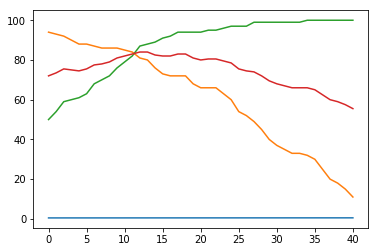

In [30]:
plt.plot(scores)

In [31]:
t = 0.491

In [32]:
path1test = 'movie_reviews/txt_sentoken/pos/holdout'
a1 = accuracyCount(path1test,posdict,negdict,1,t)
path2test = 'movie_reviews/txt_sentoken/neg/holdout'
a2 = accuracyCount(path2test,posdict,negdict,0,t)
print a1,a2

73 73
